In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/knee-osteoarthritis-dataset-with-severity
/kaggle/input/knee-osteoarthritis-dataset-with-severity/auto_test
/kaggle/input/knee-osteoarthritis-dataset-with-severity/auto_test/2
/kaggle/input/knee-osteoarthritis-dataset-with-severity/auto_test/0
/kaggle/input/knee-osteoarthritis-dataset-with-severity/auto_test/3
/kaggle/input/knee-osteoarthritis-dataset-with-severity/auto_test/1
/kaggle/input/knee-osteoarthritis-dataset-with-severity/auto_test/4
/kaggle/input/knee-osteoarthritis-dataset-with-severity/val
/kaggle/input/knee-osteoarthritis-dataset-with-severity/val/2
/kaggle/input/knee-osteoarthritis-dataset-with-severity/val/0
/kaggle/input/knee-osteoarthritis-dataset-with-severity/val/3
/kaggle/input/knee-osteoarthritis-dataset-with-severity/val/1
/kaggle/input/knee-osteoarthritis-dataset-with-severity/val/4
/kaggle/input/knee-osteoarthritis-dataset-with-severity/test
/kaggle/input/knee-osteoarthritis-dataset-with-severity/test/2
/kaggle/input/knee-osteoarthri

In [2]:
# imports
import tensorflow as tf
import timeit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Load data
base_dir="/kaggle/input/knee-osteoarthritis-dataset-with-severity/"
train_path=os.path.join(base_dir,'train')
test_path=os.path.join(base_dir,'test')
valid_path=os.path.join(base_dir,'val')

### Using Xception this time for training model

In [4]:
# Important parameters for the model
model_name="Xception"
class_names=['Healthy','Doubtful','Minimal','Moderate','Severe']
target_size=(224,224)
epochs=100
batch_size=256
img_shape=(224,224,3)

In [5]:
saved_model_path=os.path.join('models',f'model_{model_name}_ft.hdf5')

### Generating augmented and non augmented data generators

In [6]:
"""
This function used to generate augmented images for the training data
"""
def return_Augmented_Images():
    return tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.4,0.8],
    width_shift_range=[-50,0,50,30,-30],
    zoom_range=0.1,
    fill_mode="nearest",
    )

In [7]:
"""
This function used to generate augmented images for the training data
"""
def return_no_Augmentation_Images():
    return tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input,)

In [8]:
aug_datagen=return_Augmented_Images()
no_aug_datagen=return_no_Augmentation_Images()

### Training and validation data

In [9]:
train_generator=aug_datagen.flow_from_directory(train_path,class_mode="categorical",target_size=target_size,shuffle=True)
valid_generator=no_aug_datagen.flow_from_directory(valid_path,class_mode="categorical",target_size=target_size,shuffle=False)

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.


In [10]:
y_train=train_generator.labels
y_val=valid_generator.labels

### To handle class imbalance, finding class weights to use them later

In [11]:
from sklearn.utils.class_weight import compute_class_weight
unique,counts=np.unique(y_train,return_counts=True)
print("Train data:",dict(zip(unique,counts)))
class_weights=compute_class_weight(class_weight="balanced",classes=np.unique(y_train),y=y_train)
train_class_weights=dict(enumerate(class_weights))
print(train_class_weights)

Train data: {0: 2286, 1: 1046, 2: 1516, 3: 757, 4: 173}
{0: 0.5055118110236221, 1: 1.1047801147227534, 2: 0.7622691292875989, 3: 1.5265521796565389, 4: 6.679768786127168}


In [12]:
#train data
classes=np.unique(y_train)
# using some callbacks
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.01,patience=9,restore_best_weights=True)
plateau_LR=tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',factor=0.1,min_delta=0.01,min_lr=1e-10,patience=4,mode='auto')

### Using transfer learning approach to use pre trained model (Xception-Net) to save training time

In [13]:
# model
model=tf.keras.applications.xception.Xception(input_shape=img_shape,include_top=False,weights="imagenet")

83683744/83683744 [==============================] - 1s 0us/step


### Fine tuning the model

In [14]:
for layer in model.layers:
    layer.trainable=True
fine_tuned_model=tf.keras.models.Sequential([model,tf.keras.layers.GlobalAveragePooling2D(),tf.keras.layers.Dropout(0.25),
                                             tf.keras.layers.Dense(5,activation="softmax")])
fine_tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


In [15]:
fine_tuned_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
start_time=timeit.default_timer()
history=fine_tuned_model.fit(train_generator,epochs=epochs,batch_size=batch_size,
                             callbacks=[early_stopping,plateau_LR],validation_data=valid_generator,
                             class_weight=train_class_weights,verbose=1)
stop_time=timeit.default_timer()
execution_time=(stop_time-start_time)/60
print(f"Model {model_name} fine tuning executed in {execution_time:.2f} minutes")

Epoch 1/100
181/181 [==============================] - 169s 770ms/step - loss: 1.2057 - accuracy: 0.4204 - val_loss: 4.8500 - val_accuracy: 0.4322 - lr: 0.0010
Epoch 2/100
181/181 [==============================] - 98s 542ms/step - loss: 0.9149 - accuracy: 0.5427 - val_loss: 1.0922 - val_accuracy: 0.5642 - lr: 0.0010
Epoch 3/100
181/181 [==============================] - 97s 532ms/step - loss: 0.8617 - accuracy: 0.5566 - val_loss: 1.1438 - val_accuracy: 0.4891 - lr: 0.0010
Epoch 4/100
181/181 [==============================] - 97s 537ms/step - loss: 0.7969 - accuracy: 0.5805 - val_loss: 1.2618 - val_accuracy: 0.4952 - lr: 0.0010
Epoch 5/100
181/181 [==============================] - 99s 545ms/step - loss: 0.7802 - accuracy: 0.6075 - val_loss: 1.1252 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/100
181/181 [==============================] - 96s 532ms/step - loss: 0.7288 - accuracy: 0.6227 - val_loss: 1.0391 - val_accuracy: 0.5327 - lr: 0.0010
Epoch 7/100
181/181 [========================

In [16]:
fine_tuned_model.save(saved_model_path)

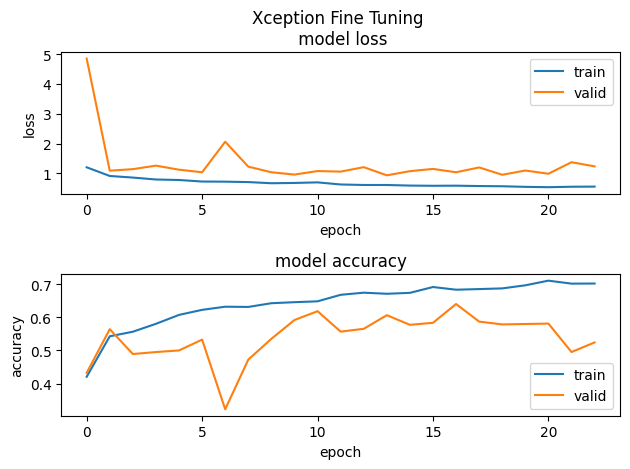

In [17]:
"""
Function to plot loss vs accuracy for the model trained
"""
def plot_loss_accuracy(model, model_name):
    fig=plt.figure()
    plt.subplot(2,1,1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train","valid"],loc="upper right")
    plt.subplot(2,1,2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train","valid"],loc="lower right")
    plt.tight_layout()
    

plot_loss_accuracy(fine_tuned_model, f"{model_name} Fine Tuning")

In [18]:
"""
Function to plot confusion matrix
"""
def plot_confusion_matrix(ytrue,ypred,class_names,model_name):
    cm=confusion_matrix(y_true=ytrue.labels,y_pred=np.argmax(ypred,axis=1))
    cmn=cm.astype("float")/cm.sum(axis=1)[:,np.newaxis]
    plt.subplots(figsize=(6,5))
    sns.heatmap(cmn,annot=True,fmt=".2f",cmap="Purples",xticklabels=class_names,yticklabels=class_names,)
    plt.title(f"Confusion Matrix -{model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)

In [19]:
"""
Functions to evaluate and predict the model performance
"""
def evaluate_model(data,name, model):
    score_model=model.evaluate(data,verbose=1)
    print(f"{name} loss: {score_model[0]:.2f}")
    print(f"{name} accuracy: {score_model[1]:.2f}")
    
def predict_model(data,model):
    predict_model=model.predict(data)
    return predict_model


evaluate_model(valid_generator, "Valid", fine_tuned_model)

26/26 [==============================] - 4s 144ms/step - loss: 0.9365 - accuracy: 0.6065
Valid loss: 0.94
Valid accuracy: 0.61


In [22]:
"""
Function to show various metrics
"""
def get_metrics(y_test,y_pred,model_name):
    acc=accuracy_score(y_test,y_pred)
    print(f"Accuracy Score - {model_name}: {acc:.2f}")
    print(classification_report(y_test, y_pred))
    
predict_model_ft = predict_model(valid_generator, fine_tuned_model)
get_metrics(valid_generator.labels,y_pred=np.argmax(predict_model_ft, axis=1),model_name=model_name)

26/26 [==============================] - 3s 106ms/step
Accuracy Score - Xception: 0.61
              precision    recall  f1-score   support

           0       0.67      0.81      0.73       328
           1       0.31      0.29      0.30       153
           2       0.77      0.41      0.54       212
           3       0.60      0.74      0.66       106
           4       0.65      0.96      0.78        27

    accuracy                           0.61       826
   macro avg       0.60      0.64      0.60       826
weighted avg       0.62      0.61      0.59       826



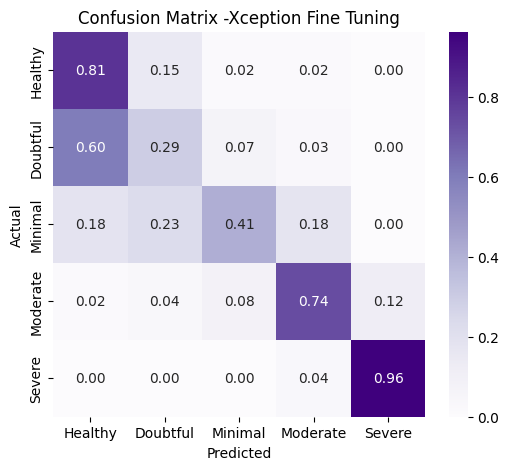

In [23]:
plot_confusion_matrix(valid_generator, predict_model_ft, class_names, f"{model_name} Fine Tuning")